In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from skimage import draw
from skimage.transform import resize
from creating_movies import BasicMovieMaker
import tensorflow as tf
from convolutional_models import BasicCNN
from tensorflow.keras.optimizers import Adam

plt.rcParams['animation.convert_path'] = 'D:/ImageMagick-7.0.9-Q16/magick.exe' # Hack for windows

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


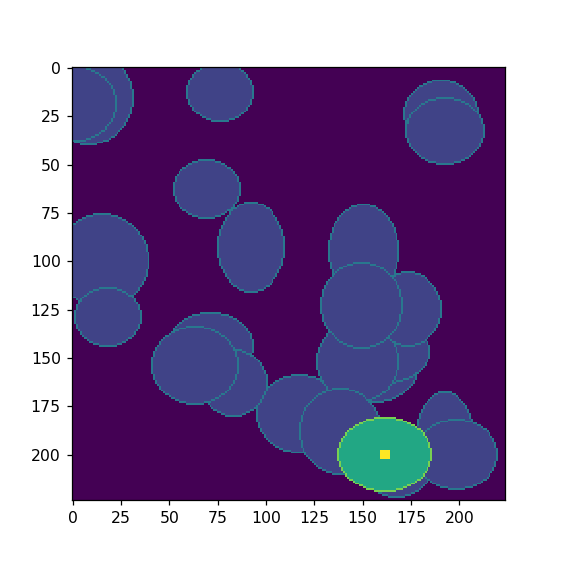

In [2]:
%matplotlib notebook
SMO = BasicMovieMaker()
SMO.make_objects(25)
movie, target, masks = SMO.make_movie(10)
fig, ani = SMO.play_movie(movie, target, masks, f_size=(5,5))

In [16]:
cnn_basic = BasicCNN((224, 224), 1)

model = cnn_basic.make_model()
model.compile(loss=weighted_BCE, optimizers=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy', balanced_accuracy])

In [17]:
# Create data:
X = []
Y = []
targ = []
for ii in range(100):
    SMO = BasicMovieMaker()
    SMO.make_objects(np.random.randint(5, 25))
    movie, target, masks = SMO.make_movie(np.random.randint(5, 15))

    X.append(movie)
    Y.append(masks)
    targ.append(target)
    
X = np.vstack(X)
Y = np.vstack(Y)
targ = np.vstack(targ)
X = np.concatenate([X[:,:,:, None], targ[:,:,:, None]], -1)

In [19]:
model.fit(X,Y, epochs=4, validation_split=0.2, batch_size=8)

Train on 741 samples, validate on 186 samples
Epoch 1/4
741/741 [==============================] - 109s 147ms/sample - loss: 0.4495 - accuracy: 0.5735 - balanced_accuracy: 0.7536 - val_loss: 0.0568 - val_accuracy: 0.9906 - val_balanced_accuracy: 0.9894
Epoch 2/4
704/741 [===========================>..] - ETA: 5s - loss: 0.0429 - accuracy: 0.9768 - balanced_accuracy: 0.9810

KeyboardInterrupt: 

In [3]:
SMO = SimpleMovieMaker()
SMO.make_objects(np.random.randint(5, 25))
x_test, bla, y_test = SMO.make_movie(50)
x_test = x_test[:, :, :, None]
y_test = y_test[:, :, :, None]
bla = bla[:, :, :, None]
x_test = np.concatenate([x_test, bla], axis=-1)
x_pred = model.predict(x_test)

NameError: name 'model' is not defined

In [4]:
%matplotlib notebook
SMO.play_movie(np.squeeze(x_test[:,:,:, 0]), np.squeeze(bla), np.squeeze(x_pred > 0.15), f_size=(5,5))

Traceback (most recent call last):
  File "D:\Miniconda\envs\MAS\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "D:\Miniconda\envs\MAS\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


NameError: name 'x_pred' is not defined

In [57]:
from skimage.io import imread
coff = imread('coffee.jpg')
coff = np.mean(coff, 2)
coff = resize(coff, (256, 256))
coff = coff / 255
tmp_targ = np.zeros((256, 256))
tmp_targ[110:118, 128:136] = 1
#plt.figure()
#plt.imshow(np.squeeze(x_pred[3][:,:,0]))

In [58]:
coff = np.stack([coff, tmp_targ], -1)[None, :, :, :]

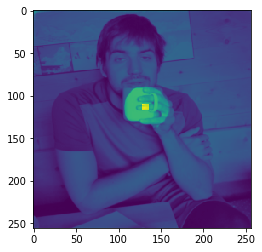

In [61]:
%matplotlib inline
pred = np.squeeze(model.predict(coff))
plt.imshow(np.squeeze(coff[:,:,:,0]) + np.squeeze(coff[:,:,:,0]) * pred + tmp_targ)
plt.savefig('hmm.jpg')

In [62]:
# Test model:
def build_simple_lstm(SMO):
    inp = Input(shape=[*SMO.objects[0].img_shape, 2])

    x, c1 = forward_block(inp, 8) # 128
    x, c2 = forward_block(x, 16) # 64
    x, c3 = forward_block(x, 32) # 32
    x, c4 = forward_block(x, 64) # 16
    x, c5 = forward_block(x, 128) # 8

    x = Conv2D(128, (3,3), padding='same')(x)
    x = Activation('relu')(x)

    #x = backward_block(x, c5, 128) # 16
    #x = backward_block(x, c4, 64) # 32
    #x = backward_block(x, c3, 32) # 64
    #x = backward_block(x, c2, 16) # 128
    #x = backward_block(x, c1, 8) # 8

    #x = Conv2D(1, (1,1), padding='same')(x)
    out = Activation('sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    
    return model

In [63]:
model_2 = build_simple_lstm(SMO)

In [66]:
k = model_2.predict(coff)

In [67]:
k.shape

(1, 8, 8, 128)